# Tail Greedy Treelet Algorithm

Comparison of treelet decomposition algorithm with tail greedy modification....

## Setup

In [147]:
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np 
import pandas as pd
import sys
import os

In [148]:
sys.path.append("../scripts")
import python_treelet_implementation as pytree
import test_treelets_mixture_models as model
import tail_greedy_treelet as tail_greedy
import utils

## Comparison: 

#### Uncorrelated factors and non-overlapping loading vectors 

In [158]:
X = model.linear_mixture_model(V = np.array([[1,1,1,0,0,0,0,0,0,0],
                                            [0,0,0,1,1,1,1,0,0,0],
                                            [0,0,0,0,0,0,0,1,1,0]])\
                                    .transpose(),
                         C = 2*np.identity(3), 
                         sigma = 1, 
                         n = 1000)

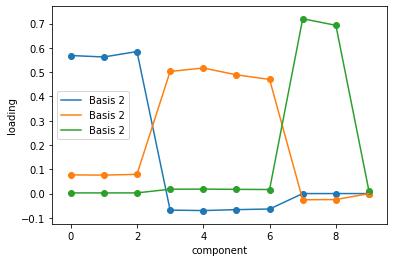

In [159]:
tree = tail_greedy.treelet_decomposition(X,.7)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

#### Correlated factors and non-overlapping loading vectors 

In [166]:
X = model.three_correlated_factors(V = np.array([[1,1,1,1,0,0,0,0,0,0],
                                                 [0,0,0,0,1,1,1,1,0,0],
                                                 [0,0,0,0,0,0,0,0,1,1]])\
                                   .transpose(),
                                   sigma = 1, 
                                   sigma1 = np.sqrt(290), 
                                   sigma2 = np.sqrt(300),
                                   c1 = -0.3, 
                                   c2 = 0.925,
                                   n = 1000
                                  )

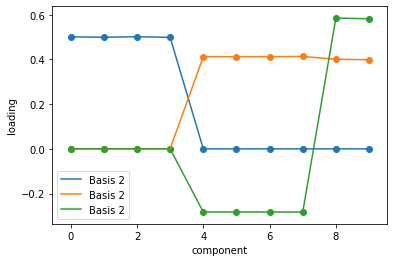

In [167]:
tree = tail_greedy.treelet_decomposition(X,.1)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

#### Uncorrelated factors and overlapping loading vectors

In [172]:
X = model.Bair_et_al(V = np.array([np.concatenate((np.repeat(1,50),np.repeat(0,350))),
                                   np.concatenate((np.repeat(0,10),np.repeat(1,90),np.repeat(0,300))),
                                   np.concatenate((np.repeat(0,200),np.repeat(1,200)))]).transpose(),
                         sigma = .5, 
                         n = 100)

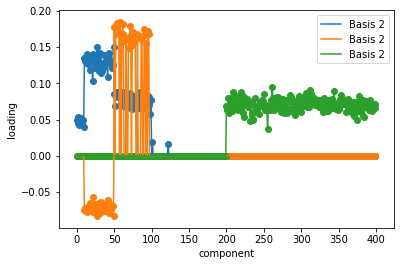

In [173]:
tree = tail_greedy.treelet_decomposition(X,.1)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]

p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

No handles with labels found to put in legend.


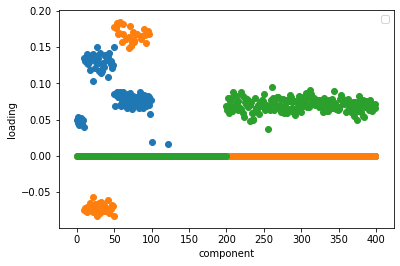

In [174]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
#     plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()